In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,mean_absolute_percentage_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# IMPORT DATA

In [ ]:
df = pd.read_csv("/content/drive/Shareddrives/DGK/DATA SPEI /CSV JATIM NTT/SPEI6-12-NTT.csv")
df.head(11)

,DATA,SPEI_6,SPEI_12
0,Jan1951,1.58284,0.86469
1,Feb1951,1.35420,0.87298
2,Mar1951,1.32954,1.15255
3,Apr1951,-0.15631,1.17137
4,May1951,-0.65283,1.21355
5,Jun1951,-0.32677,1.17630
6,Jul1951,-0.05876,1.17550
7,Aug1951,0.01873,1.09608
8,Sep1951,-0.04449,1.06286
9,Oct1951,0.48308,0.07984


In [ ]:
df.rename(columns = {"DATA":"DATE"}, inplace=True)
df.head()

,DATE,SPEI_6,SPEI_12
0,Jan1951,1.58284,0.86469
1,Feb1951,1.35420,0.87298
2,Mar1951,1.32954,1.15255
3,Apr1951,-0.15631,1.17137
4,May1951,-0.65283,1.21355


In [ ]:
df["DATE"] = pd.to_datetime(df["DATE"])
df.head()

,DATE,SPEI_6,SPEI_12
0,1951-01-01,1.58284,0.86469
1,1951-02-01,1.35420,0.87298
2,1951-03-01,1.32954,1.15255
3,1951-04-01,-0.15631,1.17137
4,1951-05-01,-0.65283,1.21355


In [ ]:
df.index = df["DATE"]
df.drop(columns = "DATE", inplace=True)
df.head()

,SPEI_6,SPEI_12
DATE,,
1951-01-01,1.58284,0.86469
1951-02-01,1.35420,0.87298
1951-03-01,1.32954,1.15255
1951-04-01,-0.15631,1.17137
1951-05-01,-0.65283,1.21355


In [ ]:
#Deskriptif statistik
df.describe()

,SPEI_6,SPEI_12
count,869.00000,869.000000
mean,0.10345,0.126210
std,0.98327,0.993474
min,-2.23473,-2.407760
25%,-0.60728,-0.616370
50%,0.14055,0.173720
75%,0.79989,0.831400
max,2.43069,2.353980


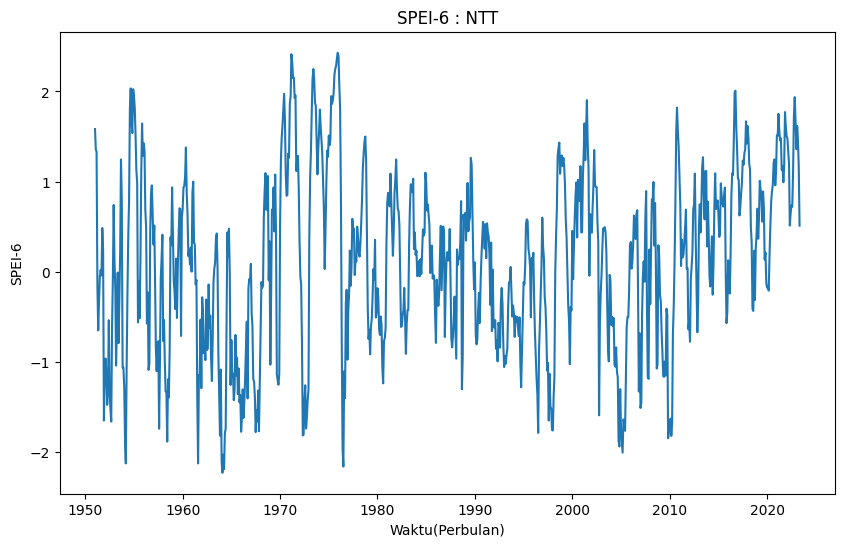

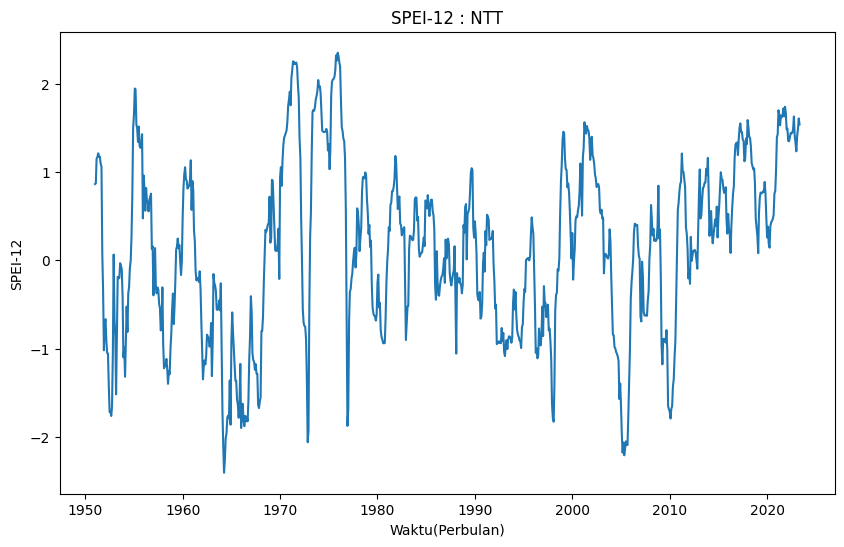

In [ ]:
#Plot Data
plt.figure(figsize = (10,6))
plt.plot(df.index,df["SPEI_6"])
plt.title("SPEI-6 : NTT")
plt.xlabel("Waktu(Perbulan)")
plt.ylabel("SPEI-6")
plt.show()

plt.figure(figsize = (10,6))
plt.plot(df.index,df["SPEI_12"])
plt.title("SPEI-12 : NTT")
plt.xlabel("Waktu(Perbulan)")
plt.ylabel("SPEI-12")
plt.show()

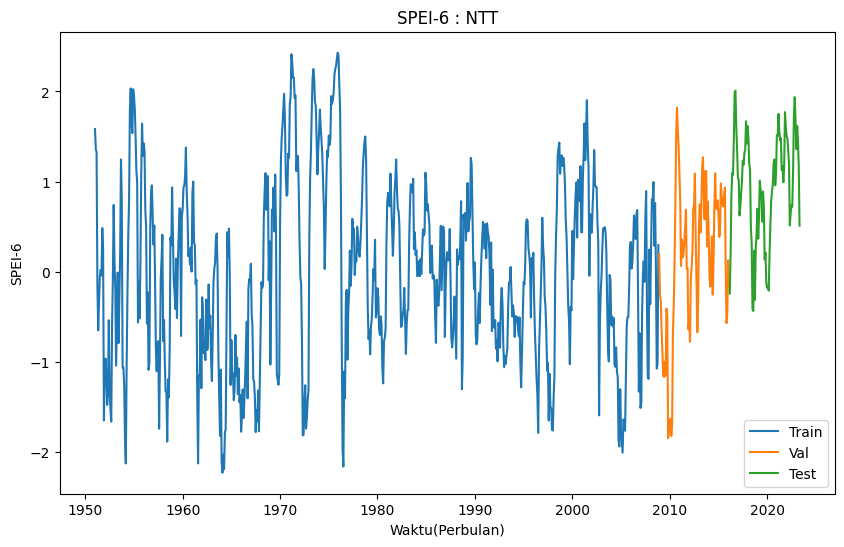

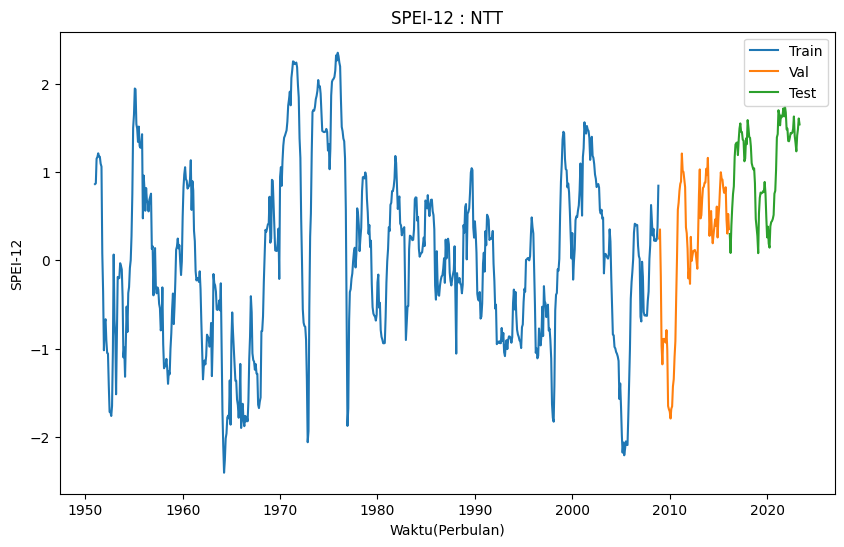

In [ ]:
q_80 = int(len(df["SPEI_6"])*0.8)
q_90 = int(len(df["SPEI_6"])*0.9)
train_data, val_data, test_data =  df.iloc[:q_80], df.iloc[q_80:q_90], df.iloc[q_90:]

plt.figure(figsize=(10,6))
plt.plot(train_data.index, train_data["SPEI_6"], label = "Train")
plt.plot(val_data.index, val_data["SPEI_6"], label = "Val")
plt.plot(test_data.index, test_data["SPEI_6"], label = "Test")
plt.title("SPEI-6 : NTT")
plt.xlabel("Waktu(Perbulan)")
plt.ylabel("SPEI-6")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(train_data.index, train_data["SPEI_12"], label = "Train")
plt.plot(val_data.index, val_data["SPEI_12"], label = "Val")
plt.plot(test_data.index, test_data["SPEI_12"], label = "Test")
plt.title("SPEI-12 : NTT")
plt.xlabel("Waktu(Perbulan)")
plt.ylabel("SPEI-12")
plt.legend()
plt.show()

In [ ]:
def window_data(data, n=12):
    windowed_data = pd.DataFrame()
    for i in range(n, 0, -1):
        windowed_data[f'Target-{i}'] = data.shift(i)
    windowed_data['Target'] = data
    return windowed_data.dropna()

In [ ]:
def df_to_X_y(df,values,window_size):
  #df_as_np = df.to_numpy()
  dates = df.index
  dates = dates[window_size:]
  X = []
  y = []
  for i in range(len(values)-window_size):
    row = [a for a in values[i:i+window_size]]
    X.append(row)
    label = values[i+window_size]
    y.append(label)
  return dates, np.array(X), np.array(y)

In [ ]:
def RNN_model(timesteps,feature):
  model = Sequential()
  model.add(SimpleRNN(200, return_sequences=True, input_shape=(timesteps, feature), activation = "tanh"))
  model.add(SimpleRNN(200))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  return model

In [ ]:
def LSTM_model(timesteps,feature):
  model = Sequential()
  model.add(LSTM(200, return_sequences=True, input_shape=(timesteps, feature), activation = "tanh"))
  model.add(LSTM(200))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  return model

In [ ]:
def GRU_model(timesteps,feature):
  model = Sequential()
  model.add(GRU(200, return_sequences=True, input_shape=(timesteps, feature), activation = "tanh"))
  model.add(GRU(200))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  return model

#SPEI_6

In [ ]:
windowed_df_spei6 = window_data(df["SPEI_6"], n=12)
windowed_df_spei6.head()

,Target-12,Target-11,Target-10,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
DATE,,,,,,,,,,,,,
1952-01-01,1.58284,1.35420,1.32954,-0.15631,-0.65283,-0.32677,-0.05876,0.01873,-0.04449,0.48308,0.24646,-1.65489,-1.13151
1952-02-01,1.35420,1.32954,-0.15631,-0.65283,-0.32677,-0.05876,0.01873,-0.04449,0.48308,0.24646,-1.65489,-1.13151,-0.96655
1952-03-01,1.32954,-0.15631,-0.65283,-0.32677,-0.05876,0.01873,-0.04449,0.48308,0.24646,-1.65489,-1.13151,-0.96655,-1.12879
1952-04-01,-0.15631,-0.65283,-0.32677,-0.05876,0.01873,-0.04449,0.48308,0.24646,-1.65489,-1.13151,-0.96655,-1.12879,-1.48145
1952-05-01,-0.65283,-0.32677,-0.05876,0.01873,-0.04449,0.48308,0.24646,-1.65489,-1.13151,-0.96655,-1.12879,-1.48145,-1.34330


In [ ]:
#Scalar
ms = MinMaxScaler()
spei6 = ms.fit_transform(df["SPEI_6"].values.reshape(-1,1))
spei6.shape

(869, 1)

In [ ]:
dates, X_spei6, y_spei6 = df_to_X_y(df["SPEI_6"], spei6, window_size=12)
dates.shape, X_spei6.shape, y_spei6.shape

((857,), (857, 12, 1), (857, 1))

In [ ]:
#Splitting Data
dates_train, X_train_spei6, y_train_spei6 = dates[:q_80], X_spei6[:q_80], y_spei6[:q_80]
dates_val, X_val_spei6, y_val_spei6 = dates[q_80:q_90], X_spei6[q_80:q_90], y_spei6[q_80:q_90]
dates_test, X_test_spei6, y_test_spei6 = dates[q_90:], X_spei6[q_90:], y_spei6[q_90:]

In [ ]:
model_RNN = RNN_model(timesteps = 12, feature = 1)
model_RNN.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 12, 200)           40400     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 200)               80200     
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 120,801
Trainable params: 120,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_RNN = model_RNN.fit(X_train_spei6, y_train_spei6,
                              validation_data=(X_val_spei6,y_val_spei6),
                              epochs = 300, steps_per_epoch=50)

Epoch 1/300
50/50 [==============================] - 9s 31ms/step - loss: 0.0953 - mean_absolute_error: 0.2429 - val_loss: 0.0184 - val_mean_absolute_error: 0.1060
Epoch 2/300
50/50 [==============================] - 2s 43ms/step - loss: 0.0441 - mean_absolute_error: 0.1655 - val_loss: 0.0120 - val_mean_absolute_error: 0.0833
Epoch 3/300
50/50 [==============================] - 2s 49ms/step - loss: 0.0282 - mean_absolute_error: 0.1336 - val_loss: 0.0106 - val_mean_absolute_error: 0.0792
Epoch 4/300
50/50 [==============================] - 1s 25ms/step - loss: 0.0220 - mean_absolute_error: 0.1189 - val_loss: 0.0092 - val_mean_absolute_error: 0.0746
Epoch 5/300
50/50 [==============================] - 1s 25ms/step - loss: 0.0191 - mean_absolute_error: 0.1061 - val_loss: 0.0103 - val_mean_absolute_error: 0.0812
Epoch 6/300
50/50 [==============================] - 2s 35ms/step - loss: 0.0185 - mean_absolute_error: 0.1043 - val_loss: 0.0087 - val_mean_absolute_error: 0.0741
Epoch 7/300
50/5

In [ ]:
model_LSTM = LSTM_model(timesteps = 12, feature = 1)
model_LSTM.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 200)           161600    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 482,601
Trainable params: 482,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_LSTM = model_LSTM.fit(X_train_spei6, y_train_spei6,
                              validation_data=(X_val_spei6,y_val_spei6),
                              epochs = 300, steps_per_epoch=50)

Epoch 1/300
50/50 [==============================] - 7s 23ms/step - loss: 0.0831 - mean_absolute_error: 0.2276 - val_loss: 0.0362 - val_mean_absolute_error: 0.1495
Epoch 2/300
50/50 [==============================] - 0s 7ms/step - loss: 0.0379 - mean_absolute_error: 0.1556 - val_loss: 0.0354 - val_mean_absolute_error: 0.1482
Epoch 3/300
50/50 [==============================] - 0s 7ms/step - loss: 0.0363 - mean_absolute_error: 0.1526 - val_loss: 0.0322 - val_mean_absolute_error: 0.1427
Epoch 4/300
50/50 [==============================] - 0s 7ms/step - loss: 0.0350 - mean_absolute_error: 0.1516 - val_loss: 0.0283 - val_mean_absolute_error: 0.1340
Epoch 5/300
50/50 [==============================] - 0s 7ms/step - loss: 0.0337 - mean_absolute_error: 0.1487 - val_loss: 0.0323 - val_mean_absolute_error: 0.1436
Epoch 6/300
50/50 [==============================] - 0s 7ms/step - loss: 0.0326 - mean_absolute_error: 0.1450 - val_loss: 0.0254 - val_mean_absolute_error: 0.1270
Epoch 7/300
50/50 [==

In [ ]:
model_GRU = GRU_model(timesteps = 12, feature = 1)
model_GRU.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])
model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 12, 200)           121800    
                                                                 
 gru_1 (GRU)                 (None, 200)               241200    
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 363,201
Trainable params: 363,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_GRU = model_GRU.fit(X_train_spei6, y_train_spei6,
                              validation_data=(X_val_spei6,y_val_spei6),
                              epochs = 300, steps_per_epoch=50)

Epoch 1/300
50/50 [==============================] - 5s 21ms/step - loss: 0.0670 - mean_absolute_error: 0.1971 - val_loss: 0.0238 - val_mean_absolute_error: 0.1243
Epoch 2/300
50/50 [==============================] - 0s 10ms/step - loss: 0.0251 - mean_absolute_error: 0.1271 - val_loss: 0.0214 - val_mean_absolute_error: 0.1181
Epoch 3/300
50/50 [==============================] - 0s 9ms/step - loss: 0.0232 - mean_absolute_error: 0.1219 - val_loss: 0.0182 - val_mean_absolute_error: 0.1101
Epoch 4/300
50/50 [==============================] - 0s 10ms/step - loss: 0.0218 - mean_absolute_error: 0.1169 - val_loss: 0.0180 - val_mean_absolute_error: 0.1095
Epoch 5/300
50/50 [==============================] - 0s 9ms/step - loss: 0.0206 - mean_absolute_error: 0.1151 - val_loss: 0.0158 - val_mean_absolute_error: 0.1032
Epoch 6/300
50/50 [==============================] - 0s 9ms/step - loss: 0.0186 - mean_absolute_error: 0.1083 - val_loss: 0.0140 - val_mean_absolute_error: 0.0976
Epoch 7/300
50/50 [

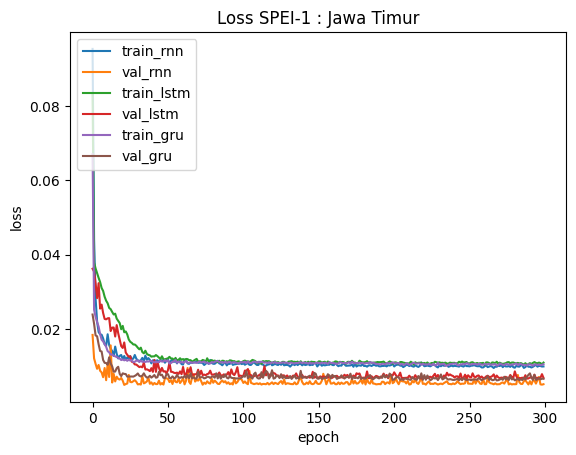

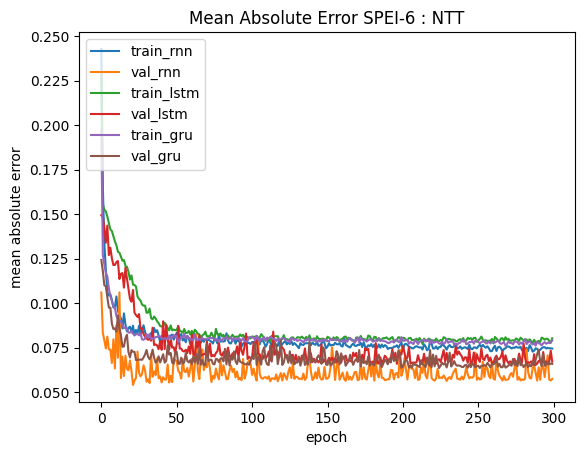

In [ ]:
plt.plot(history_RNN.history['loss'], label = "train_rnn")
plt.plot(history_RNN.history['val_loss'], label = "val_rnn")
plt.plot(history_LSTM.history['loss'], label = "train_lstm")
plt.plot(history_LSTM.history['val_loss'], label = "val_lstm")
plt.plot(history_GRU.history['loss'], label = "train_gru")
plt.plot(history_GRU.history['val_loss'], label = "val_gru")
plt.title('Loss SPEI-1 : Jawa Timur')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history_RNN.history['mean_absolute_error'], label = "train_rnn")
plt.plot(history_RNN.history['val_mean_absolute_error'], label = "val_rnn")
plt.plot(history_LSTM.history['mean_absolute_error'], label = "train_lstm")
plt.plot(history_LSTM.history['val_mean_absolute_error'], label = "val_lstm")
plt.plot(history_GRU.history['mean_absolute_error'], label = "train_gru")
plt.plot(history_GRU.history['val_mean_absolute_error'], label = "val_gru")
plt.title('Mean Absolute Error SPEI-6 : NTT')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#Denormalisasi Data
train_spei6_predictions_rnn = model_RNN.predict(X_train_spei6)
train_spei6_predictions_rnn = ms.inverse_transform(train_spei6_predictions_rnn)

train_spei6_predictions_lstm = model_LSTM.predict(X_train_spei6)
train_spei6_predictions_lstm = ms.inverse_transform(train_spei6_predictions_lstm)

train_spei6_predictions_gru = model_GRU.predict(X_train_spei6)
train_spei6_predictions_gru = ms.inverse_transform(train_spei6_predictions_gru)

val_spei6_predictions_rnn = model_RNN.predict(X_val_spei6)
val_spei6_predictions_rnn = ms.inverse_transform(val_spei6_predictions_rnn)

val_spei6_predictions_lstm = model_LSTM.predict(X_val_spei6)
val_spei6_predictions_lstm = ms.inverse_transform(val_spei6_predictions_lstm)

val_spei6_predictions_gru = model_GRU.predict(X_val_spei6)
val_spei6_predictions_gru = ms.inverse_transform(val_spei6_predictions_gru)

test_spei6_predictions_rnn = model_RNN.predict(X_test_spei6)
test_spei6_predictions_rnn = ms.inverse_transform(test_spei6_predictions_rnn)

test_spei6_predictions_lstm = model_LSTM.predict(X_test_spei6)
test_spei6_predictions_lstm = ms.inverse_transform(test_spei6_predictions_lstm)

test_spei6_predictions_gru = model_GRU.predict(X_test_spei6)
test_spei6_predictions_gru = ms.inverse_transform(test_spei6_predictions_gru)

y_spei6_plot = ms.inverse_transform(y_spei6)
y_train_spei6 = ms.inverse_transform(y_train_spei6)
y_val_spei6 = ms.inverse_transform(y_val_spei6)
y_test_spei6 = ms.inverse_transform(y_test_spei6)

3/3 [==============================] - 0s 4ms/step


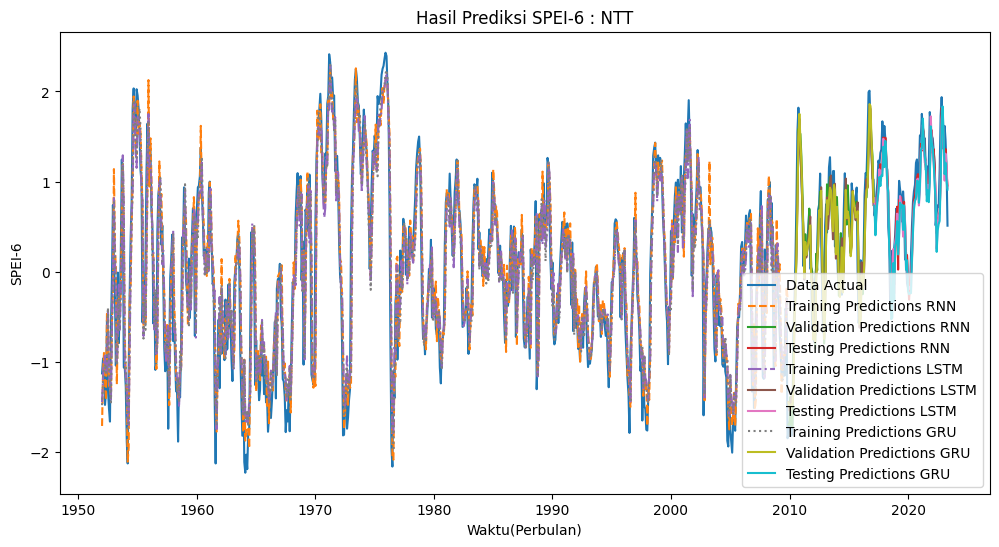

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(dates, y_spei6_plot, label = "Data Actual")
plt.plot(dates_train, train_spei6_predictions_rnn, label = "Training Predictions RNN", linestyle = "--")
plt.plot(dates_val, val_spei6_predictions_rnn, label = "Validation Predictions RNN")
plt.plot(dates_test, test_spei6_predictions_rnn, label = "Testing Predictions RNN")
plt.plot(dates_train, train_spei6_predictions_lstm, label = "Training Predictions LSTM", linestyle = "-.")
plt.plot(dates_val, val_spei6_predictions_lstm, label = "Validation Predictions LSTM")
plt.plot(dates_test, test_spei6_predictions_lstm, label = "Testing Predictions LSTM")
plt.plot(dates_train, train_spei6_predictions_gru, label = "Training Predictions GRU", linestyle = "dotted")
plt.plot(dates_val, val_spei6_predictions_gru, label = "Validation Predictions GRU")
plt.plot(dates_test, test_spei6_predictions_gru, label = "Testing Predictions GRU")
plt.title("Hasil Prediksi SPEI-6 : NTT")
plt.xlabel("Waktu(Perbulan)")
plt.ylabel("SPEI-6")
plt.legend()

In [ ]:

# Train set
print("MAE_train_RNN = ", mean_absolute_error(y_train_spei6, train_spei6_predictions_rnn))
print("MAPE_train_RNN = ", mean_absolute_percentage_error(y_train_spei6, train_spei6_predictions_rnn))
print("RMSE_train_RNN = ", mean_squared_error(y_train_spei6, train_spei6_predictions_rnn, squared=False))
print("R2_train_RNN = ", r2_score(y_train_spei6, train_spei6_predictions_rnn), "\n")

print("MAE_train_LSTM = ", mean_absolute_error(y_train_spei6, train_spei6_predictions_lstm))
print("MAPE_train_LSTM = ", mean_absolute_percentage_error(y_train_spei6, train_spei6_predictions_lstm))
print("RMSE_train_LSTM = ", mean_squared_error(y_train_spei6, train_spei6_predictions_lstm, squared=False))
print("R2_train_LSTM = ", r2_score(y_train_spei6, train_spei6_predictions_lstm), "\n")

print("MAE_train_GRU = ", mean_absolute_error(y_train_spei6, train_spei6_predictions_gru))
print("MAPE_train_GRU = ", mean_absolute_percentage_error(y_train_spei6, train_spei6_predictions_gru))
print("RMSE_train_GRU = ", mean_squared_error(y_train_spei6, train_spei6_predictions_gru, squared=False))
print("R2_train_GRU = ", r2_score(y_train_spei6, train_spei6_predictions_gru), "\n")

# Validation set
print("MAE_val_RNN = ", mean_absolute_error(y_val_spei6, val_spei6_predictions_rnn))
print("MAPE_val_RNN = ", mean_absolute_percentage_error(y_val_spei6, val_spei6_predictions_rnn))
print("RMSE_val_RNN = ", mean_squared_error(y_val_spei6, val_spei6_predictions_rnn, squared=False))
print("R2_val_RNN = ", r2_score(y_val_spei6, val_spei6_predictions_rnn), "\n")

print("MAE_val_LSTM = ", mean_absolute_error(y_val_spei6, val_spei6_predictions_lstm))
print("MAPE_val_LSTM = ", mean_absolute_percentage_error(y_val_spei6, val_spei6_predictions_lstm))
print("RMSE_val_LSTM = ", mean_squared_error(y_val_spei6, val_spei6_predictions_lstm, squared=False))
print("R2_val_LSTM = ", r2_score(y_val_spei6, val_spei6_predictions_lstm), "\n")

print("MAE_val_GRU = ", mean_absolute_error(y_val_spei6, val_spei6_predictions_gru))
print("MAPE_val_GRU = ", mean_absolute_percentage_error(y_val_spei6, val_spei6_predictions_gru))
print("RMSE_val_GRU = ", mean_squared_error(y_val_spei6, val_spei6_predictions_gru, squared=False))
print("R2_val_GRU = ", r2_score(y_val_spei6, val_spei6_predictions_gru), "\n")

# Test set
print("MAE_test_RNN = ", mean_absolute_error(y_test_spei6, test_spei6_predictions_rnn))
print("MAPE_test_RNN = ", mean_absolute_percentage_error(y_test_spei6, test_spei6_predictions_rnn))
print("RMSE_test_RNN = ", mean_squared_error(y_test_spei6, test_spei6_predictions_rnn, squared=False))
print("R2_test_RNN = ", r2_score(y_test_spei6, test_spei6_predictions_rnn), "\n")

print("MAE_test_LSTM = ", mean_absolute_error(y_test_spei6, test_spei6_predictions_lstm))
print("MAPE_test_LSTM = ", mean_absolute_percentage_error(y_test_spei6, test_spei6_predictions_lstm))
print("RMSE_test_LSTM = ", mean_squared_error(y_test_spei6, test_spei6_predictions_lstm, squared=False))
print("R2_test_LSTM = ", r2_score(y_test_spei6, test_spei6_predictions_lstm), "\n")

print("MAE_test_GRU = ", mean_absolute_error(y_test_spei6, test_spei6_predictions_gru))
print("MAPE_test_GRU = ", mean_absolute_percentage_error(y_test_spei6, test_spei6_predictions_gru))
print("RMSE_test_GRU = ", mean_squared_error(y_test_spei6, test_spei6_predictions_gru, squared=False))
print("R2_test_GRU = ", r2_score(y_test_spei6, test_spei6_predictions_gru), "\n")


MAE_train_RNN =  0.32750295388316786
MAPE_train_RNN =  2.565639173648103
RMSE_train_RNN =  0.44512941778811527
R2_train_RNN =  0.7969056308324391 

MAE_train_LSTM =  0.3557210088612251
MAPE_train_LSTM =  2.1254398495879125
RMSE_train_LSTM =  0.4685282105234033
R2_train_LSTM =  0.7749926114018091 

MAE_train_GRU =  0.3510208510166429
MAPE_train_GRU =  1.9621145123449777
RMSE_train_GRU =  0.4621836593135131
R2_train_GRU =  0.7810452040864403 

MAE_val_RNN =  0.26802780638904106
MAPE_val_RNN =  2.9743822043089656
RMSE_val_RNN =  0.3328929245844695
R2_val_RNN =  0.8318913462682593 

MAE_val_LSTM =  0.313261695030818
MAPE_val_LSTM =  3.4079993259836905
RMSE_val_LSTM =  0.38503587124373845
R2_val_LSTM =  0.7751031749243955 

MAE_val_GRU =  0.3074043171485676
MAPE_val_GRU =  3.0933866577211684
RMSE_val_GRU =  0.3773558973482374
R2_val_GRU =  0.7839853408828743 

MAE_test_RNN =  0.21455839882338987
MAPE_test_RNN =  0.3989454322685085
RMSE_test_RNN =  0.2743848265902718
R2_test_RNN =  0.7766710

#SPEI_12

In [ ]:
windowed_df_spei12 = window_data(df["SPEI_12"], n=12)
windowed_df_spei12.head()

,Target-12,Target-11,Target-10,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
DATE,,,,,,,,,,,,,
1952-01-01,0.86469,0.87298,1.15255,1.17137,1.21355,1.17630,1.17550,1.09608,1.06286,0.07984,-0.35400,-1.01954,-0.70376
1952-02-01,0.87298,1.15255,1.17137,1.21355,1.17630,1.17550,1.09608,1.06286,0.07984,-0.35400,-1.01954,-0.70376,-0.66753
1952-03-01,1.15255,1.17137,1.21355,1.17630,1.17550,1.09608,1.06286,0.07984,-0.35400,-1.01954,-0.70376,-0.66753,-0.90918
1952-04-01,1.17137,1.21355,1.17630,1.17550,1.09608,1.06286,0.07984,-0.35400,-1.01954,-0.70376,-0.66753,-0.90918,-1.05060
1952-05-01,1.21355,1.17630,1.17550,1.09608,1.06286,0.07984,-0.35400,-1.01954,-0.70376,-0.66753,-0.90918,-1.05060,-1.05702


In [ ]:
#Scalar
ms = MinMaxScaler()
spei12 = ms.fit_transform(df["SPEI_12"].values.reshape(-1,1))
spei12.shape

(869, 1)

In [ ]:
dates, X_spei12, y_spei12 = df_to_X_y(df["SPEI_12"], spei12, window_size=12)
dates.shape, X_spei12.shape, y_spei12.shape

((857,), (857, 12, 1), (857, 1))

In [ ]:
#Splitting Data
dates_train, X_train_spei12, y_train_spei12 = dates[:q_80], X_spei12[:q_80], y_spei12[:q_80]
dates_val, X_val_spei12, y_val_spei12 = dates[q_80:q_90], X_spei12[q_80:q_90], y_spei12[q_80:q_90]
dates_test, X_test_spei12, y_test_spei12 = dates[q_90:], X_spei12[q_90:], y_spei12[q_90:]

In [ ]:
model_RNN = RNN_model(X_train_spei12.shape[1],X_train_spei12.shape[2])
model_RNN.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])
model_RNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 12, 200)           40400     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 200)               80200     
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 120,801
Trainable params: 120,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_RNN = model_RNN.fit(X_train_spei12, y_train_spei12,
                              validation_data=(X_val_spei12,y_val_spei12),
                              epochs = 300, steps_per_epoch=50)

Epoch 1/300
50/50 [==============================] - 4s 31ms/step - loss: 0.0434 - mean_absolute_error: 0.1652 - val_loss: 0.0071 - val_mean_absolute_error: 0.0684
Epoch 2/300
50/50 [==============================] - 1s 26ms/step - loss: 0.0219 - mean_absolute_error: 0.1163 - val_loss: 0.0152 - val_mean_absolute_error: 0.1087
Epoch 3/300
50/50 [==============================] - 2s 31ms/step - loss: 0.0231 - mean_absolute_error: 0.1194 - val_loss: 0.0092 - val_mean_absolute_error: 0.0825
Epoch 4/300
50/50 [==============================] - 2s 45ms/step - loss: 0.0115 - mean_absolute_error: 0.0823 - val_loss: 0.0033 - val_mean_absolute_error: 0.0444
Epoch 5/300
50/50 [==============================] - 2s 32ms/step - loss: 0.0114 - mean_absolute_error: 0.0827 - val_loss: 0.0053 - val_mean_absolute_error: 0.0597
Epoch 6/300
50/50 [==============================] - 1s 26ms/step - loss: 0.0097 - mean_absolute_error: 0.0748 - val_loss: 0.0029 - val_mean_absolute_error: 0.0424
Epoch 7/300
50/5

In [ ]:
history_LSTM = model_LSTM.fit(X_train_spei12, y_train_spei12,
                              validation_data=(X_val_spei12,y_val_spei12),
                              epochs = 300, steps_per_epoch=50)

Epoch 1/300
50/50 [==============================] - 0s 8ms/step - loss: 0.0043 - mean_absolute_error: 0.0494 - val_loss: 0.0022 - val_mean_absolute_error: 0.0363
Epoch 2/300
50/50 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_absolute_error: 0.0464 - val_loss: 0.0023 - val_mean_absolute_error: 0.0379
Epoch 3/300
50/50 [==============================] - 0s 7ms/step - loss: 0.0042 - mean_absolute_error: 0.0475 - val_loss: 0.0021 - val_mean_absolute_error: 0.0358
Epoch 4/300
50/50 [==============================] - 0s 7ms/step - loss: 0.0040 - mean_absolute_error: 0.0467 - val_loss: 0.0028 - val_mean_absolute_error: 0.0423
Epoch 5/300
50/50 [==============================] - 0s 7ms/step - loss: 0.0040 - mean_absolute_error: 0.0469 - val_loss: 0.0022 - val_mean_absolute_error: 0.0371
Epoch 6/300
50/50 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_absolute_error: 0.0459 - val_loss: 0.0029 - val_mean_absolute_error: 0.0432
Epoch 7/300
50/50 [===

In [ ]:
history_GRU = model_GRU.fit(X_train_spei12, y_train_spei12,
                              validation_data=(X_val_spei12,y_val_spei12),
                              epochs = 300, steps_per_epoch=50)

Epoch 1/300
50/50 [==============================] - 0s 8ms/step - loss: 0.0043 - mean_absolute_error: 0.0496 - val_loss: 0.0022 - val_mean_absolute_error: 0.0365
Epoch 2/300
50/50 [==============================] - 0s 7ms/step - loss: 0.0042 - mean_absolute_error: 0.0474 - val_loss: 0.0024 - val_mean_absolute_error: 0.0391
Epoch 3/300
50/50 [==============================] - 0s 7ms/step - loss: 0.0041 - mean_absolute_error: 0.0477 - val_loss: 0.0026 - val_mean_absolute_error: 0.0407
Epoch 4/300
50/50 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_absolute_error: 0.0463 - val_loss: 0.0024 - val_mean_absolute_error: 0.0389
Epoch 5/300
50/50 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_absolute_error: 0.0469 - val_loss: 0.0031 - val_mean_absolute_error: 0.0459
Epoch 6/300
50/50 [==============================] - 0s 7ms/step - loss: 0.0040 - mean_absolute_error: 0.0470 - val_loss: 0.0023 - val_mean_absolute_error: 0.0376
Epoch 7/300
50/50 [===

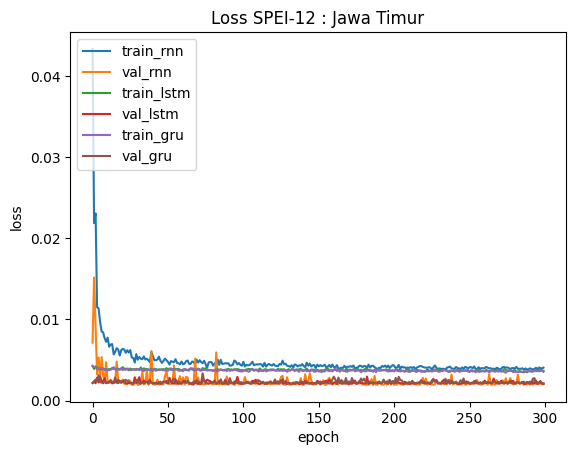

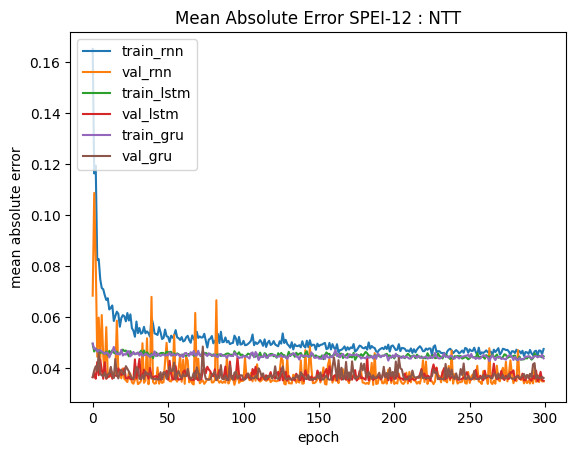

In [ ]:
plt.plot(history_RNN.history['loss'], label = "train_rnn")
plt.plot(history_RNN.history['val_loss'], label = "val_rnn")
plt.plot(history_LSTM.history['loss'], label = "train_lstm")
plt.plot(history_LSTM.history['val_loss'], label = "val_lstm")
plt.plot(history_GRU.history['loss'], label = "train_gru")
plt.plot(history_GRU.history['val_loss'], label = "val_gru")
plt.title('Loss SPEI-12 : Jawa Timur')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history_RNN.history['mean_absolute_error'], label = "train_rnn")
plt.plot(history_RNN.history['val_mean_absolute_error'], label = "val_rnn")
plt.plot(history_LSTM.history['mean_absolute_error'], label = "train_lstm")
plt.plot(history_LSTM.history['val_mean_absolute_error'], label = "val_lstm")
plt.plot(history_GRU.history['mean_absolute_error'], label = "train_gru")
plt.plot(history_GRU.history['val_mean_absolute_error'], label = "val_gru")
plt.title('Mean Absolute Error SPEI-12 : NTT')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#Denormalisasi Data
train_spei12_predictions_rnn = model_RNN.predict(X_train_spei12)
train_spei12_predictions_rnn = ms.inverse_transform(train_spei12_predictions_rnn)

train_spei12_predictions_lstm = model_LSTM.predict(X_train_spei12)
train_spei12_predictions_lstm = ms.inverse_transform(train_spei12_predictions_lstm)

train_spei12_predictions_gru = model_GRU.predict(X_train_spei12)
train_spei12_predictions_gru = ms.inverse_transform(train_spei12_predictions_gru)

val_spei12_predictions_rnn = model_RNN.predict(X_val_spei12)
val_spei12_predictions_rnn = ms.inverse_transform(val_spei12_predictions_rnn)

val_spei12_predictions_lstm = model_LSTM.predict(X_val_spei12)
val_spei12_predictions_lstm = ms.inverse_transform(val_spei12_predictions_lstm)

val_spei12_predictions_gru = model_GRU.predict(X_val_spei12)
val_spei12_predictions_gru = ms.inverse_transform(val_spei12_predictions_gru)

test_spei12_predictions_rnn = model_RNN.predict(X_test_spei12)
test_spei12_predictions_rnn = ms.inverse_transform(test_spei12_predictions_rnn)

test_spei12_predictions_lstm = model_LSTM.predict(X_test_spei12)
test_spei12_predictions_lstm = ms.inverse_transform(test_spei12_predictions_lstm)

test_spei12_predictions_gru = model_GRU.predict(X_test_spei12)
test_spei12_predictions_gru = ms.inverse_transform(test_spei12_predictions_gru)

y_spei12_plot = ms.inverse_transform(y_spei12)
y_train_spei12 = ms.inverse_transform(y_train_spei12)
y_val_spei12 = ms.inverse_transform(y_val_spei12)
y_test_spei12 = ms.inverse_transform(y_test_spei12)

3/3 [==============================] - 0s 5ms/step


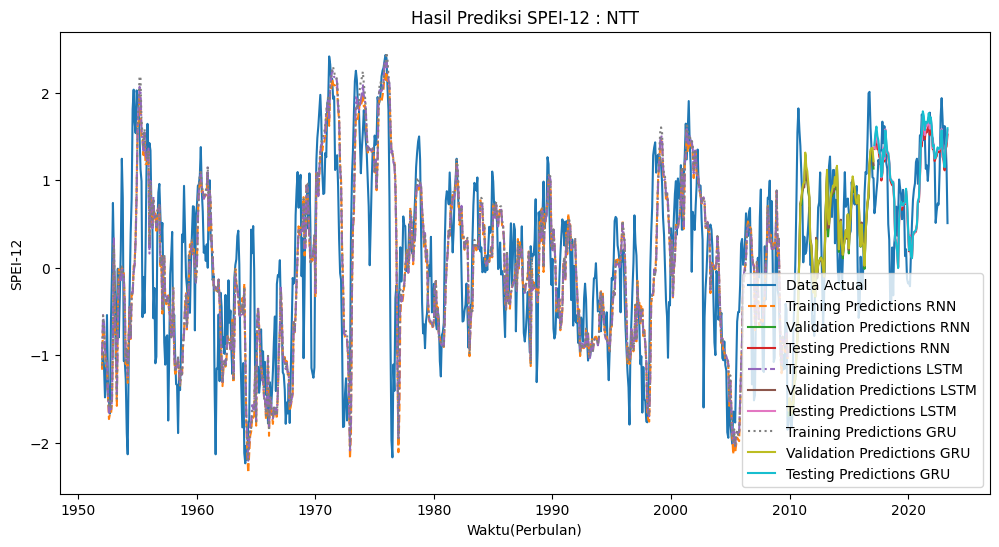

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(dates, y_spei6_plot, label = "Data Actual")
plt.plot(dates_train, train_spei12_predictions_rnn, label = "Training Predictions RNN", linestyle = "--")
plt.plot(dates_val, val_spei12_predictions_rnn, label = "Validation Predictions RNN")
plt.plot(dates_test, test_spei12_predictions_rnn, label = "Testing Predictions RNN")
plt.plot(dates_train, train_spei12_predictions_lstm, label = "Training Predictions LSTM", linestyle = "-.")
plt.plot(dates_val, val_spei12_predictions_lstm, label = "Validation Predictions LSTM")
plt.plot(dates_test, test_spei12_predictions_lstm, label = "Testing Predictions LSTM")
plt.plot(dates_train, train_spei12_predictions_gru, label = "Training Predictions GRU", linestyle = "dotted")
plt.plot(dates_val, val_spei12_predictions_gru, label = "Validation Predictions GRU")
plt.plot(dates_test, test_spei12_predictions_gru, label = "Testing Predictions GRU")
plt.title("Hasil Prediksi SPEI-12 : NTT")
plt.xlabel("Waktu(Perbulan)")
plt.ylabel("SPEI-12")
plt.legend()

In [ ]:

# Train set
print("MAE_train_RNN = ", mean_absolute_error(y_train_spei12, train_spei12_predictions_rnn))
print("MAPE_train_RNN = ", mean_absolute_percentage_error(y_train_spei12, train_spei12_predictions_rnn))
print("RMSE_train_RNN = ", mean_squared_error(y_train_spei12, train_spei12_predictions_rnn, squared=False))
print("R2_train_RNN = ", r2_score(y_train_spei12, train_spei12_predictions_rnn), "\n")

print("MAE_train_LSTM = ", mean_absolute_error(y_train_spei12, train_spei12_predictions_lstm))
print("MAPE_train_LSTM = ", mean_absolute_percentage_error(y_train_spei12, train_spei12_predictions_lstm))
print("RMSE_train_LSTM = ", mean_squared_error(y_train_spei12, train_spei12_predictions_lstm, squared=False))
print("R2_train_LSTM = ", r2_score(y_train_spei12, train_spei12_predictions_lstm), "\n")

print("MAE_train_GRU = ", mean_absolute_error(y_train_spei12, train_spei12_predictions_gru))
print("MAPE_train_GRU = ", mean_absolute_percentage_error(y_train_spei12, train_spei12_predictions_gru))
print("RMSE_train_GRU = ", mean_squared_error(y_train_spei12, train_spei12_predictions_gru, squared=False))
print("R2_train_GRU = ", r2_score(y_train_spei12, train_spei12_predictions_gru), "\n")

# Validation set
print("MAE_val_RNN = ", mean_absolute_error(y_val_spei12, val_spei12_predictions_rnn))
print("MAPE_val_RNN = ", mean_absolute_percentage_error(y_val_spei12, val_spei12_predictions_rnn))
print("RMSE_val_RNN = ", mean_squared_error(y_val_spei12, val_spei12_predictions_rnn, squared=False))
print("R2_val_RNN = ", r2_score(y_val_spei12, val_spei12_predictions_rnn), "\n")

print("MAE_val_LSTM = ", mean_absolute_error(y_val_spei12, val_spei12_predictions_lstm))
print("MAPE_val_LSTM = ", mean_absolute_percentage_error(y_val_spei12, val_spei12_predictions_lstm))
print("RMSE_val_LSTM = ", mean_squared_error(y_val_spei12, val_spei12_predictions_lstm, squared=False))
print("R2_val_LSTM = ", r2_score(y_val_spei12, val_spei12_predictions_lstm), "\n")

print("MAE_val_GRU = ", mean_absolute_error(y_val_spei12, val_spei12_predictions_gru))
print("MAPE_val_GRU = ", mean_absolute_percentage_error(y_val_spei12, val_spei12_predictions_gru))
print("RMSE_val_GRU = ", mean_squared_error(y_val_spei12, val_spei12_predictions_gru, squared=False))
print("R2_val_GRU = ", r2_score(y_val_spei12, val_spei12_predictions_gru), "\n")

# Test set
print("MAE_test_RNN = ", mean_absolute_error(y_test_spei12, test_spei12_predictions_rnn))
print("MAPE_test_RNN = ", mean_absolute_percentage_error(y_test_spei12, test_spei12_predictions_rnn))
print("RMSE_test_RNN = ", mean_squared_error(y_test_spei12, test_spei12_predictions_rnn, squared=False))
print("R2_test_RNN = ", r2_score(y_test_spei12, test_spei12_predictions_rnn), "\n")

print("MAE_test_LSTM = ", mean_absolute_error(y_test_spei12, test_spei12_predictions_lstm))
print("MAPE_test_LSTM = ", mean_absolute_percentage_error(y_test_spei12, test_spei12_predictions_lstm))
print("RMSE_test_LSTM = ", mean_squared_error(y_test_spei12, test_spei12_predictions_lstm, squared=False))
print("R2_test_LSTM = ", r2_score(y_test_spei12, test_spei12_predictions_lstm), "\n")

print("MAE_test_GRU = ", mean_absolute_error(y_test_spei12, test_spei12_predictions_gru))
print("MAPE_test_GRU = ", mean_absolute_percentage_error(y_test_spei12, test_spei12_predictions_gru))
print("RMSE_test_GRU = ", mean_squared_error(y_test_spei12, test_spei12_predictions_gru, squared=False))
print("R2_test_GRU = ", r2_score(y_test_spei12, test_spei12_predictions_gru), "\n")


MAE_train_RNN =  0.19483257293802553
MAPE_train_RNN =  1.211808473077891
RMSE_train_RNN =  0.27656912036108305
R2_train_RNN =  0.9227256406355625 

MAE_train_LSTM =  0.19023365070558035
MAPE_train_LSTM =  1.1114969039904965
RMSE_train_LSTM =  0.2716482348292423
R2_train_LSTM =  0.9254510019017744 

MAE_train_GRU =  0.19386626185335828
MAPE_train_GRU =  1.2490057675564707
RMSE_train_GRU =  0.2724145349881106
R2_train_GRU =  0.925029813929942 

MAE_val_RNN =  0.16547866835594183
MAPE_val_RNN =  1.199976607262384
RMSE_val_RNN =  0.21446994662455784
R2_val_RNN =  0.9167931568114511 

MAE_val_LSTM =  0.16637050792139155
MAPE_val_LSTM =  1.2362764042978895
RMSE_val_LSTM =  0.2162692949468123
R2_val_LSTM =  0.9153911315447186 

MAE_val_GRU =  0.1716369715713393
MAPE_val_GRU =  1.2361237306394408
RMSE_val_GRU =  0.22003312733410127
R2_val_GRU =  0.9124205323622782 

MAE_test_RNN =  0.12512788998281954
MAPE_test_RNN =  0.16852178264819503
RMSE_test_RNN =  0.16144523795234325
R2_test_RNN =  0.88

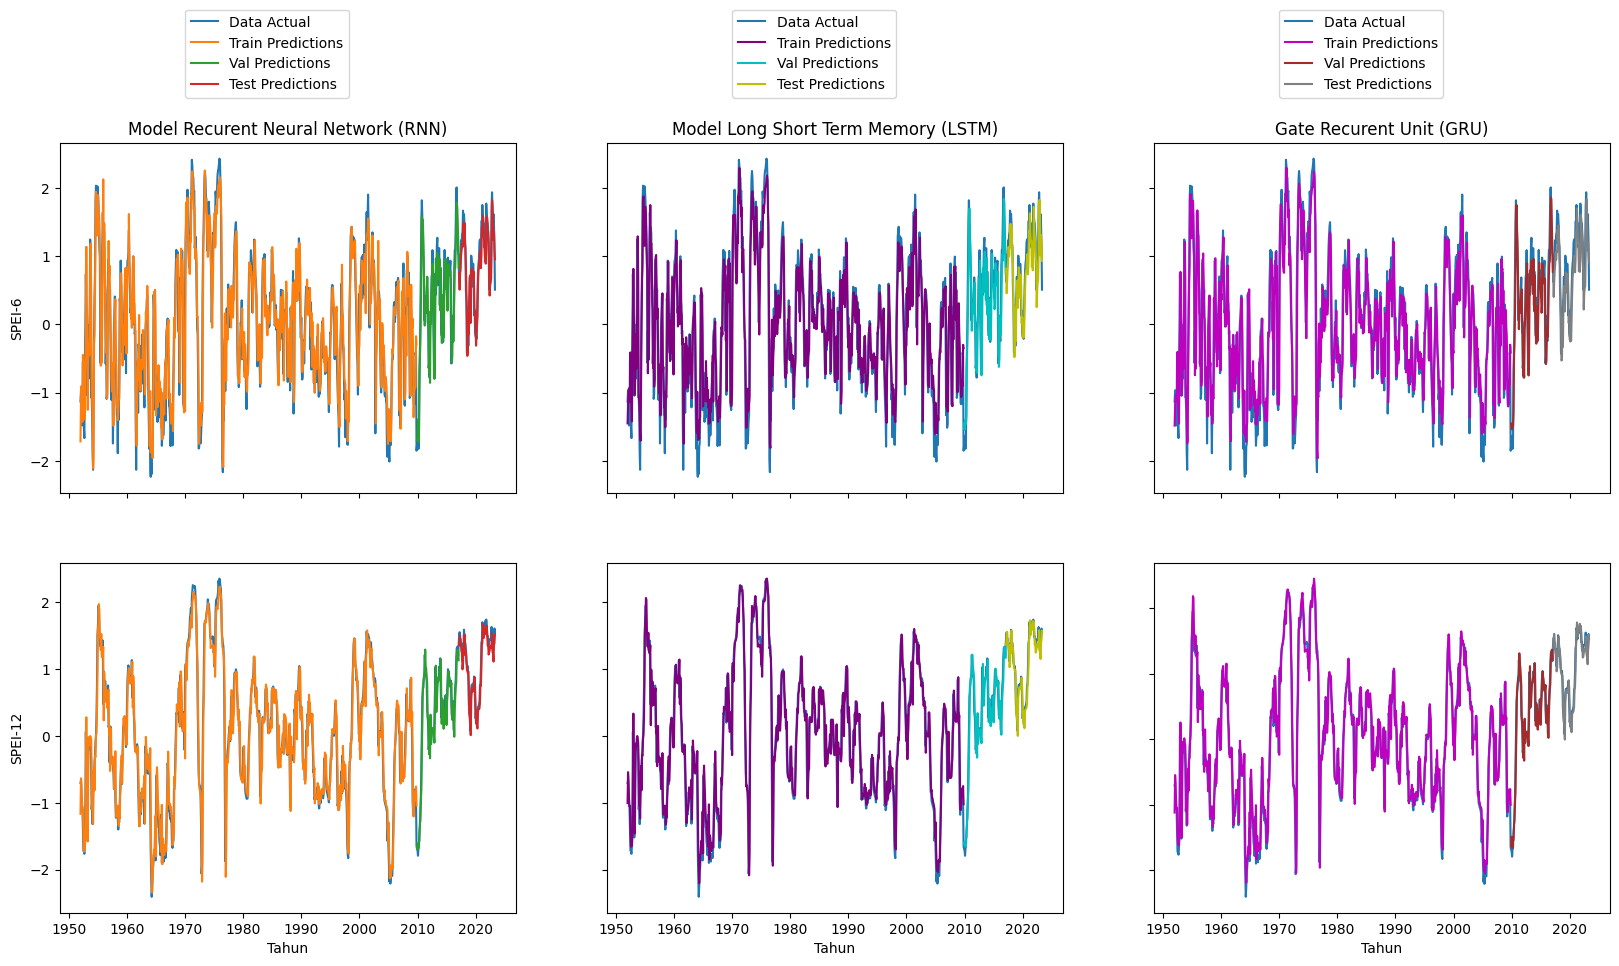

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,3, figsize=(20,10))
#fig.suptitle('Prediksi SPEI NTT')
#RNN
axs[0,0].plot(dates, y_spei6_plot, label = "Data Actual")
axs[0,0].plot(dates_train, train_spei6_predictions_rnn, label = "Train Predictions")
axs[0,0].plot(dates_val, val_spei6_predictions_rnn, label = "Val Predictions")
axs[0,0].plot(dates_test, test_spei6_predictions_rnn, label = "Test Predictions")
axs[0,0].set_ylabel("SPEI-6")
axs[0,0].set_title("Model Recurent Neural Network (RNN)")
axs[0,0].legend(bbox_to_anchor=(0.65,1.4))
axs[1,0].plot(dates, y_spei12_plot)
axs[1,0].plot(dates_train, train_spei12_predictions_rnn, label = "Train Predictions")
axs[1,0].plot(dates_val, val_spei12_predictions_rnn, label = "Val Predictions")
axs[1,0].plot(dates_test, test_spei12_predictions_rnn, label = "Test Predictions")
axs[1,0].set_ylabel("SPEI-12")


#LSTM
axs[0,1].plot(dates, y_spei6_plot, label = "Data Actual")
axs[0,1].plot(dates_train, train_spei6_predictions_lstm, color = "purple", label = "Train Predictions")
axs[0,1].plot(dates_val, val_spei6_predictions_lstm, color = 'c', label = "Val Predictions")
axs[0,1].plot(dates_test, test_spei6_predictions_lstm, color = 'y', label = "Test Predictions")
axs[0,1].legend(bbox_to_anchor=(0.65,1.4))
axs[0,1].set_title("Model Long Short Term Memory (LSTM)")
axs[1,1].plot(dates, y_spei12_plot)
axs[1,1].plot(dates_train, train_spei12_predictions_lstm, color = 'purple')
axs[1,1].plot(dates_val, val_spei12_predictions_lstm, color = "c")
axs[1,1].plot(dates_test, test_spei12_predictions_lstm, color = "y")


#GRU
axs[0,2].plot(dates, y_spei6_plot, label = "Data Actual")
axs[0,2].plot(dates_train, train_spei6_predictions_gru, color = "m", label = "Train Predictions")
axs[0,2].plot(dates_val, val_spei6_predictions_gru, color = "brown", label = "Val Predictions")
axs[0,2].plot(dates_test, test_spei6_predictions_gru, color = "grey", label = "Test Predictions")
axs[0,2].legend(bbox_to_anchor=(0.65,1.4))
axs[0,2].set_title("Gate Recurent Unit (GRU)")
axs[1,2].plot(dates, y_spei12_plot)
axs[1,2].plot(dates_train, train_spei12_predictions_gru, color = "m")
axs[1,2].plot(dates_val, val_spei12_predictions_gru, color = "brown")
axs[1,2].plot(dates_test, test_spei12_predictions_gru, color = "grey")

for ax in axs.flat:
  ax.set(xlabel = 'Tahun')

for ax in axs.flat:
  ax.label_outer()

plt.savefig('grafik.png')

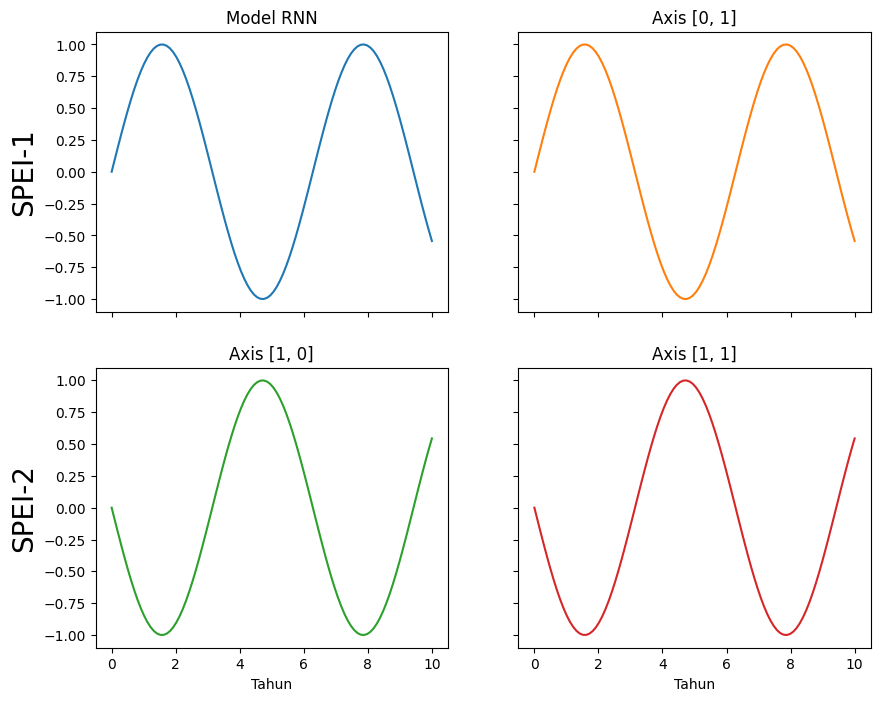

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0,10,100)
y = np.sin(x)
fig, axs = plt.subplots(2, 2, figsize=(10,8))
axs[0, 0].plot(x, y)
axs[0, 0].set_title('Model RNN')
axs[0,0].set_ylabel("SPEI-1", fontsize=20)
axs[0, 1].plot(x, y, 'tab:orange')
axs[0, 1].set_title('Axis [0, 1]')
axs[1, 0].plot(x, -y, 'tab:green')
axs[1,0].set_ylabel("SPEI-2", fontsize=20)
axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(x, -y, 'tab:red')
axs[1, 1].set_title('Axis [1, 1]')

for ax in axs.flat:
  ax.set(xlabel = "Tahun")
for ax in axs.flat:
  ax.label_outer()